In [1]:
# Importing data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

test = pd.read_csv("/Users/Cory/Desktop/Predicting_Disease_Spread/Data/dengue_features_test.csv")
train = pd.read_csv("/Users/Cory/Desktop/Predicting_Disease_Spread/Data/dengue_features_train.csv")
labels = pd.read_csv("/Users/Cory/Desktop/Predicting_Disease_Spread/Data/dengue_labels_train.csv")

#Merge

df = pd.merge(train, labels, on = ["city", "year", "weekofyear"])

#Convert city to dummy

mapping = {'sj': 0, 'iq': 1}
df = df.replace(mapping)

#Interpolate

df = df.interpolate(how = "linear")

#To Date Time

import datetime
df['date'] = df['week_start_date'].astype(str).apply(lambda x: pd.to_datetime(x, format='%Y-%m-%d'))

#Week columns to Datetime

from datetime import date
df['month'] = df['date'].dt.month

# Convert City to Dummy

mapping = {'sj': 0, 'iq': 1}
train2 = train.replace(mapping)

df.dtypes

# Split Train and Test

#Create Y

y = df.loc[:, ['total_cases']]
y.head(3)

#Features List

features=[
'city',
 'year',
 'weekofyear',
     'month',
 #'week_start_date',
 'ndvi_ne',
 'ndvi_nw',
 'ndvi_se',
 'ndvi_sw',
 'precipitation_amt_mm',
 'reanalysis_air_temp_k',
 'reanalysis_avg_temp_k',
 'reanalysis_dew_point_temp_k',
 'reanalysis_max_air_temp_k',
 'reanalysis_min_air_temp_k',
 'reanalysis_precip_amt_kg_per_m2',
 'reanalysis_relative_humidity_percent',
 'reanalysis_sat_precip_amt_mm',
 'reanalysis_specific_humidity_g_per_kg',
 'reanalysis_tdtr_k',
 'station_avg_temp_c',
 'station_diur_temp_rng_c',
 'station_max_temp_c',
 'station_min_temp_c',
 'station_precip_mm',
 #'total_cases',
 #'date',
]

#Create X

X = df.loc[:, features]
X.head(3)

from sklearn.model_selection import train_test_split, GridSearchCV
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=123)

# Ensemble Model


In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Set seed for reproducibility
SEED=1

# Instantiate lr
lr = LogisticRegression(random_state=SEED)

# Instantiate knn
knn = KNeighborsClassifier(n_neighbors=27)

# Instantiate dt
dt = DecisionTreeClassifier(random_state=SEED)

# Define the list classifiers
classifiers = [('Logistic Regression', lr), ('K Nearest Neighbours', knn), ('Classification Tree', dt)]

# Iterate over the pre-defined list of classifiers
for clf_name, clf in classifiers:    
  
    # Fit clf to the training set
    clf.fit(X_train, y_train)    
  
    # Predict y_pred
    y_pred = clf.predict(X_test)
    
    # Calculate accuracy
    mae = mean_absolute_error(y_test, y_pred)

  
    # Evaluate clf's accuracy on the test set
    print('{:s} : {:.3f}'.format(clf_name, mae))

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
# Instantiate a VotingClassifier vc 
vc = VotingClassifier(estimators=classifiers)     

# Fit vc to the training set
vc.fit(X_train, y_train)   

# Evaluate the test set predictions
y_pred_vote = vc.predict(X_test)

# Calculate accuracy score
MAE = mean_absolute_error(y_test, y_pred_vote)
print('Votting Classifier: ', MAE)

Logistic Regression : 18.195
K Nearest Neighbours : 17.182
Classification Tree : 14.808
Votting Classifier:  17.503424657534246


# Bagging

In [5]:
# Import BaggingClassifier
from sklearn.ensemble import BaggingClassifier

# Instantiate dt
dt = DecisionTreeClassifier(random_state=1)

# Instantiate bc
bc = BaggingClassifier(base_estimator=dt, n_estimators=50, random_state=1)

# Fit bc to the training set
bc.fit(X_train, y_train)

# Predict test set labels
y_pred = bc.predict(X_test)
# Evaluate acc_test
acc_test_bag = mean_absolute_error(y_test, y_pred)
print('Bagging Test ', acc_test_bag)

Bagging Test  13.643835616438356


# Out of The Bag

In [6]:
# Instantiate dt
dt = DecisionTreeClassifier(random_state=1)
# Instantiate bc
bc = BaggingClassifier(base_estimator=dt, 
                       n_estimators=50,
                       oob_score=True,
                       random_state=1)

# Fit bc to the training set 
bc.fit(X_train, y_train)

# Predict test set labels
y_pred = bc.predict(X_test)

# Evaluate test set accuracy
acc_test = mean_absolute_error(y_test, y_pred)

# Evaluate OOB accuracy
acc_oob = bc.oob_score_
print('Out of the Bag Test ', acc_test)

Out of the Bag Test  13.643835616438356


# Random Forest

In [7]:
from sklearn.ensemble import RandomForestRegressor

# Instantiate rf
rf = RandomForestRegressor(n_estimators=50,
                           random_state=1)
                           
# Fit rf to the training set            
rf.fit(X_train, y_train)             

# Predict the test set labels
y_pred = rf.predict(X_test)

# Evaluate test set accuracy
acc_test = mean_absolute_error(y_test, y_pred)
print('Random Forest ', acc_test)

Random Forest  10.68068493150685


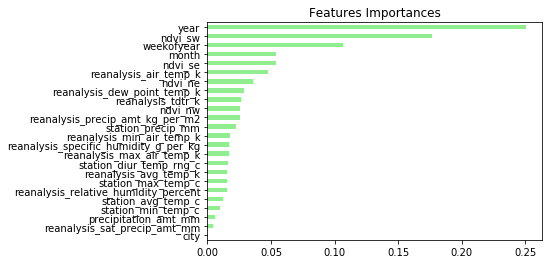

In [8]:
import matplotlib.pyplot as plt

# Create a pd.Series of features importances
importances = pd.Series(data=rf.feature_importances_,
                        index= X_train.columns)

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances')
plt.show()

# Gradient Boosting Regressor

In [9]:
# Import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Instantiate gb
gb = GradientBoostingRegressor(
                               n_estimators=500,
                               random_state=1)
# Fit gb to the training set
gb.fit(X_train, y_train)

# Predict test set labels
y_pred = gb.predict(X_test)

acc_test = mean_absolute_error(y_test, y_pred)
print('Gradient Boosting Regressor ', acc_test)

Gradient Boosting Regressor  11.15953681389596
